In [35]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

# os.chdir("C:\\Users\\Taha\\Desktop\\Hate Speach")

In [36]:
main_data=pd.read_csv("train.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,1,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation
...,...,...
52577,1,you're all niggers
52578,1,you're such a retard i hope you get type 2 diabetes and die from a sugar rush you fucking faggot @Dare_ILK
52579,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;"
52580,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again


,label
0,29719
1,22863


0s : 1s  ::   1.3 : 1


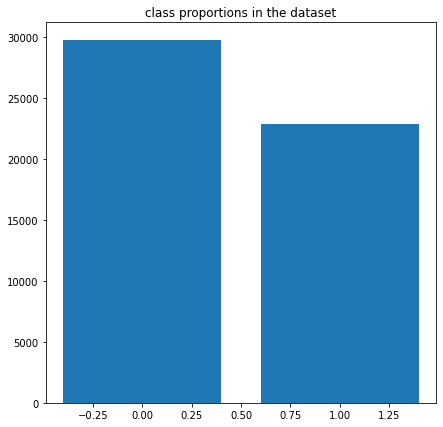

In [37]:
#Check class distribution in dependent variable 
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

,label
0,29719
1,22863


0s : 1s  ::   1.3 : 1


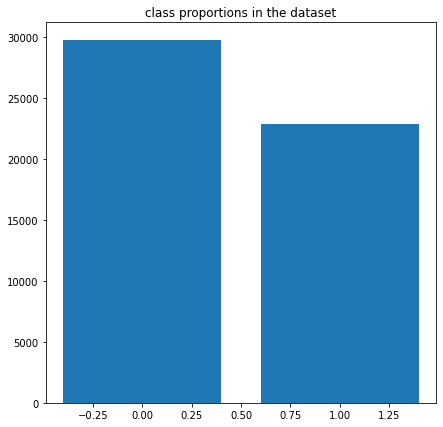

In [38]:
#Balancing the dataset using Oversampling
data1=data[data['label']==1]
data0=data[data['label']==0]
# data=pd.concat([data,data1,data1], axis=0) #This line duplicated the minority class data
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [39]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)


def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [40]:
#preprocess train dataset
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split())) 

train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [41]:
#classes proportion in dependent variable in train and test dataset
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
0    23780
1    18285
Name: label, dtype: int64
42065
===========Test Data =========
0    5939
1    4578
Name: label, dtype: int64
10517


In [42]:
#train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:33652
Class distributionCounter({0: 19024, 1: 14628})
Valid data len:8413
Class distributionCounter({0: 4756, 1: 3657})


In [43]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [44]:
#convert sentences to sequences of numbers
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )

#padding 
maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())


print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

#tensorflow dataset preparation
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:33652
Class distributionCounter({0: 19024, 1: 14628})
Validation data len:8413
Class distributionCounter({0: 4756, 1: 3657})
Test data len:10517
Class distributionCounter({0: 5939, 1: 4578})


In [45]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[  19    4  280  771  331    4  302  219  173    3  443  551 7608 1915
   50    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[28752   782   382    36   822    39     1     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)
======Test dataset ====
tf.Tensor(
[ 126  754    3  539 4195    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    

In [46]:
#model preparation
max_features =50000
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            800016    
                                                                 
 dropout_9 (Dropout)         (None, 50, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 16)            2112      
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               410112    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                

In [47]:
print(len(model.layers))

9


In [48]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
33/33 [==============================] - 12s 274ms/step - loss: 2.5620 - binary_accuracy: 0.5639 - val_loss: 1.2023 - val_binary_accuracy: 0.5653
Epoch 2/10
33/33 [==============================] - 9s 260ms/step - loss: 0.9424 - binary_accuracy: 0.5786 - val_loss: 0.7825 - val_binary_accuracy: 0.7569
Epoch 3/10
33/33 [==============================] - 9s 272ms/step - loss: 0.5896 - binary_accuracy: 0.8448 - val_loss: 0.4163 - val_binary_accuracy: 0.9261
Epoch 4/10
33/33 [==============================] - 9s 260ms/step - loss: 0.4223 - binary_accuracy: 0.9292 - val_loss: 0.3347 - val_binary_accuracy: 0.9448
Epoch 5/10
33/33 [==============================] - 9s 259ms/step - loss: 0.3500 - binary_accuracy: 0.9489 - val_loss: 0.3239 - val_binary_accuracy: 0.9425
Epoch 6/10
33/33 [==============================] - 9s 262ms/step - loss: 0.3218 - binary_accuracy: 0.9566 - val_loss: 0.3045 - val_binary_accuracy: 0.9452
Epoch 7/10
33/33 [==============================] - 9s 264ms/st

In [49]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

[[2.3516658e-01]
 [8.8992208e-02]
 [1.5136898e-03]
 [8.1166446e-02]
 [1.2131780e-02]
 [9.8559260e-04]
 [1.2788069e-01]
 [3.9509296e-02]
 [9.9948657e-01]
 [9.9255288e-01]]


In [50]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)

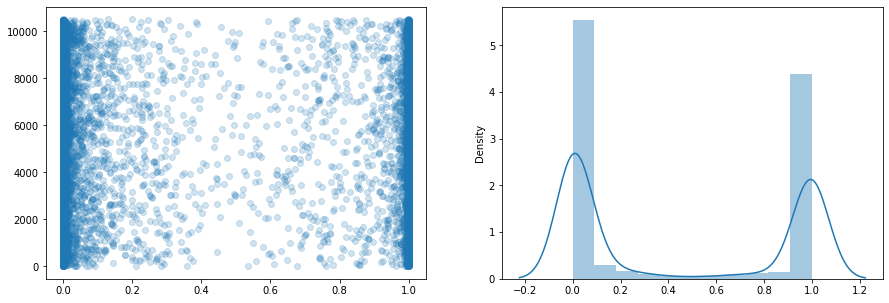

In [51]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

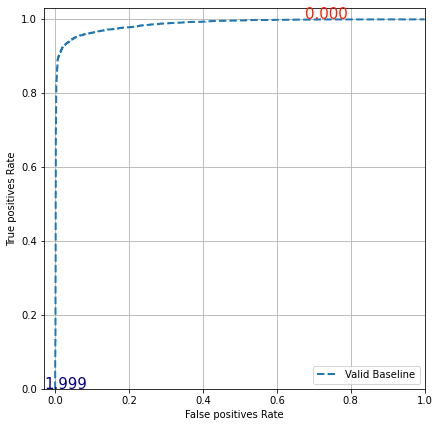

In [52]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [53]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5939
           1       0.98      0.91      0.95      4578

    accuracy                           0.95     10517
   macro avg       0.96      0.95      0.95     10517
weighted avg       0.96      0.95      0.95     10517



## TESTING MODEL ON THE TEST DATASET PROVIDED

In [54]:
final_test=pd.read_csv("test.csv")
# final_test=pd.read_csv("train.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))

array([[ 126,  754,    3, ...,    0,    0,    0],
       [   2,  544,   73, ...,    0,    0,    0],
       [   1,  293, 2249, ...,    0,    0,    0],
       ...,
       [   1,   13, 3193, ...,    0,    0,    0],
       [   4,   34, 1715, ...,    0,    0,    0],
       [   2,   68,    1, ...,    0,    0,    0]], dtype=int32)

array([[34880,     1, 13725, ...,     0,     0,     0],
       [    2,   130,     1, ...,     0,     0,     0],
       [  757,   997,  1058, ...,     0,     0,     0],
       ...,
       [   33,    88,   526, ...,     0,     0,     0],
       [  359,   837,   188, ...,     0,     0,     0],
       [   40,     4,     6, ...,     0,     0,     0]], dtype=int32)

In [55]:
#predict on actual test data
predictions = model.predict(f_test)

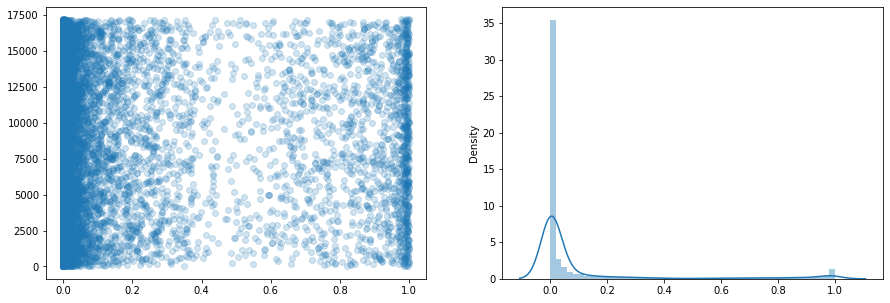

In [56]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.2)
ax2=sns.distplot(predictions)

In [57]:
#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as HATE speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]


,tweet,pred_sentiment
19,thought factory bbc neutrality right wing fascism politics media blm brexit trump leadership gt3,1.0
26,chick gets fucked hottest naked lady,1.0
33,suppo the taiji fisherman bullying racism tweet4taiji thecove seashepherd,1.0
110,hey user ivanka bracelet you feel good profiting from xenophobia misogyny hatred grabyourwallet,1.0
141,you might libtard libtard sjw liberal politics,1.0
...,...,...
17148,grew fucked upð¤ its fucked upð¥ believing you better place but its fucking upð© âï¸,1.0
17162,hoes never have anything else better than hoe,1.0
17188,black professor demonizes proposes nazi style confiscation white assets like 1930s germany breaking,1.0
17192,thought factory leftright polarisation trump uselections2016 leadership politics brexit blm gt3,1.0


In [58]:
#actual tweets categorized as hate speech
# final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

In [59]:
# actual tweets categorized as NORMAL speech
# final_test.iloc[ftest[ftest['pred_sentiment']==0].index]

In [60]:
#processed tweets categorized as NORMAL speech
ftest[ftest['pred_sentiment']==0]

,tweet,pred_sentiment
0,studiolife aislife requires passion dedication willpower find newmaterialsâ¦,0.0
1,user white supremacists want everyone see the new â birdsâ movie â and hereâs why,0.0
2,safe ways heal your acne altwaystoheal healthy healing,0.0
3,the and the cursed child book for reservations already yes where when ððð harrypotter pottermore favorite,0.0
4,3rd bihday amazing hilarious nephew eli ahmir uncle dave loves you and missesâ¦,0.0
...,...,...
17191,2damntuffruffmufftechnocityng005web1997ukhxint web hardcore 1gabba,0.0
17193,feeling like mermaid ð hairflip neverready formal wedding gown dresses mermaid â¦,0.0
17194,hillary campaigned today ohioomg amp used words like assetsampliability never once did clinton say theeword radicalization,0.0
17195,happy work conference right mindset leads cultureofdevelopment organizations work mindset,0.0


In [69]:
# def test1(incoming_string):
# print("incoming_string (from server): ")
# incoming_string = input()

flg = 1
while flg:

  print("Input: ('0' to exit)")
  incoming_string = input()
  # os.system('clear')
  if incoming_string=='0':
    print("Exit successful!!")
    break

  # print("hereeeeee")
  a1 = 100
  id1 = np.int64(a1)
  a2 = 101
  id2 = np.int64(a2)


  # print(type(incoming_string))

  data = {'id': [id1,id2],
          'text': ['Example String',incoming_string]
          }

  final_test = pd.DataFrame(data)
  # final_test
  # products_list = df.values.tolist()
  # print(type(final_test))


  # final_test=pd.read_csv("test.csv")

  ftest2=final_test.copy()

  ftest2.drop(columns=['id'],axis=1,inplace=True)


  # print(type(ftest))

  ftest2['text'] = ftest2['text'].apply(remove_emoji)
  ftest2['text'] = ftest2['text'].apply(clean_text)
  # print(type(ftest['text'][0]))
  f_test  = np.array( tokenizer.texts_to_sequences(ftest2['text'].tolist()) )
  f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

  # display((x_test))
  # display((f_test))

  predictions = model.predict(f_test)




  #mapping prediction to 1 or 0
  cutoff = 0.82
  ftest2['pred_sentiment']= predictions

  # ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
  # ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)



  # ///////////////////////////////
  # ftest2['pred_sentiment'] = np.where((ftest2.pred_sentiment >= cutoff),1,ftest2.pred_sentiment)
  # ftest2['pred_sentiment'] = np.where((ftest2.pred_sentiment < cutoff),0,ftest2.pred_sentiment)
  # ///////////////////////////////////////////////////////


  # print((ftest['pred_sentiment'][0]))




  

  #processed texts categorized as hate speech
  # pd.set_option('display.max_colwidth', None)


  # ftest[ftest['pred_sentiment']==1]

  # final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

  # p2 = predictions
  # # predictions
  # p2.sort()
  # print(type(predictions))
  # for i in range(100):
  print(ftest2)

Input: ('0' to exit)
BEGIN
             text  pred_sentiment
0  example string        0.004620
1           begin        0.002918
Input: ('0' to exit)
INSTANCE
             text  pred_sentiment
0  example string        0.004620
1        instance        0.021062
Input: ('0' to exit)


KeyboardInterrupt: ignored

In [62]:
# words watch
heart = 1
brain = 1
porn = 0

In [ ]:
#good results
#917

In [67]:
# !pip install flask-ngrok

In [68]:

# from flask import Flask,request,Response
# from flask_ngrok import run_with_ngrok
# app = Flask(__name__)
# run_with_ngrok(app)   
  
# @app.route("/",methods=['GET', 'POST','DELETE', 'PATCH'])
# def home():
#   if request.method == 'POST':
#     av = request.form.get('name')
#     print("here->",av)
#     return Response("{'Hate':'1'}", status=201, mimetype='application/json')
 
# app.run()